# Google Earth Engine

#### Using `contextily` to display imagery from Google Earth Engine (GEE)

In this notebook, we show how you can access data from Google Earth Engine through Google's `ee` package and create static (base)maps using `contextily`. We also show how this relates to the standard [way suggested by Google](https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb) to display imagery in an interactive context using `folium`.

## Requirements

See official guidance from Google [here](https://developers.google.com/earth-engine/python_install). Let's import the API package:

In [1]:
import ee
ee.__version__

'0.1.221'

And before we can access Earth Engine imagery, we need to authenticate ourselves. If you're on a browser where you're logged on your Google account, this should be straightforward (and a one off):

In [ ]:
# Cell cleared to avoid pasting tokens, etc.
ee.Authenticate()

And once past Google security check, we can initialize the session:

In [2]:
ee.Initialize()

## Interactive way using `folium`

Google has an illustration with the great [`folium`](https://python-visualization.github.io/folium/) library, which provides interactive access to EE imagery. 

In this example, replicated from the [original link](https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb), we create an interactive map of the [SRTM elevation model](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) from NASA:

In [3]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Read DEM
dem = ee.Image('USGS/SRTMGL1_003')

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## Rendering GEE with `contextily`

Now, because GEE provides access to imagery through the popular XYZ standard, which is fully supported by `contextily`, we can also render its imagery statically.

In [4]:
import contextily
import matplotlib.pyplot as plt

### SRTM elevation model
Let's decouple the data access from the rendering in the example above. First, we specify the dataset (`dem`) and pick the visualisation parameters (`vis_params`):

In [5]:
# Read DEM
dem = ee.Image('USGS/SRTMGL1_003')

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
    'transparency': 0.5
}

With this, we can obtain from Google a bespoke base URL:

In [6]:
src = dem.getMapId(vis_params)["tile_fetcher"].url_format
src

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/maps/e772f0b6ccf89aae965d25d9887de682-80246485c60c87ca3f19bec781b4a24e/tiles/{z}/{x}/{y}'

Note that, because this requires login with you account, the link above will not work directly outside the session. So if you want to access it, you'll need your own login and then replicate the code to get your own URL to the dataset.

Now let's pick a place to create a map for. For example, Switzerland. We can pull down the part of the GEE-provided DEM for this region using, for example, the place API in `contextily`. All we need to specify is to point the `source` argument to the URL provided above:

In [7]:
sw = contextily.Place("Switzerland", source=src)

And voila, we have it ready to plot:

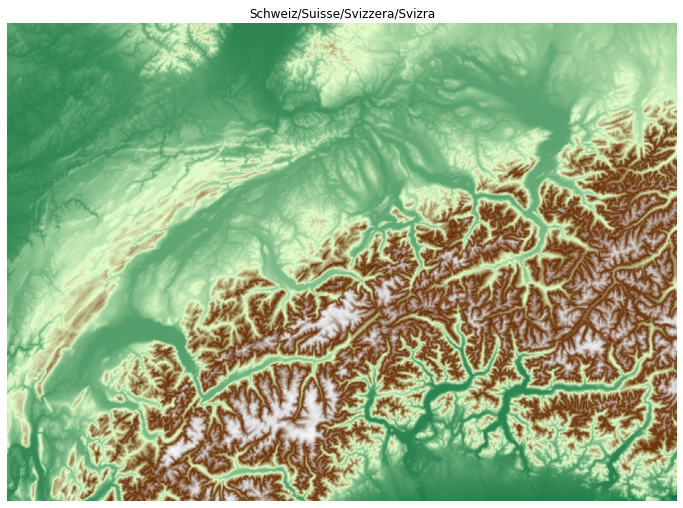

In [8]:
sw.plot()

## Landsat - 8

Here is another example to access Landsat imagery at two different points in time. To do this, we will need to create the base URL for the two dates. We will use the case of [Hurricane Harvey](https://en.wikipedia.org/wiki/Hurricane_Harvey) to extract two snapshots of Houston before and after the storm.

First, we specify the dataset (`l8`), the location we want to query for clean/cloudfree images (`houston`) and the dates for before (`pre`) and after (`aft`), as well as the visual parameters we want for the resulting imagery (`vis_params`):

In [9]:
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
houston = ee.Geometry.Point(-95.3908, 29.7850)
pre = l8.filterDate("2017-07-15", "2017-08-16")\
        .filterBounds(houston)\
        .mosaic()
aft = l8.filterDate("2017-08-17", "2017-09-30")\
        .filterBounds(houston)\
        .mosaic()
viz_params = {
  "bands": ["B4", "B3", "B2"],
  "gain": '0.1, 0.1, 0.1', 
  "scale":20
}

With this, we can create the URL for imagery before (`url_pre`) and after (`url_aft`) the hurricane:

In [10]:
url_pre = pre.getMapId(viz_params)["tile_fetcher"].url_format
url_aft = aft.getMapId(viz_params)["tile_fetcher"].url_format

To create a map with `contextily`, we can now use the place API again:

In [11]:
map_pre = contextily.Place("Houston, TX", source=url_pre)
map_aft = contextily.Place("Houston, TX", source=url_aft)

Now we can plot the image of before and after the storm:

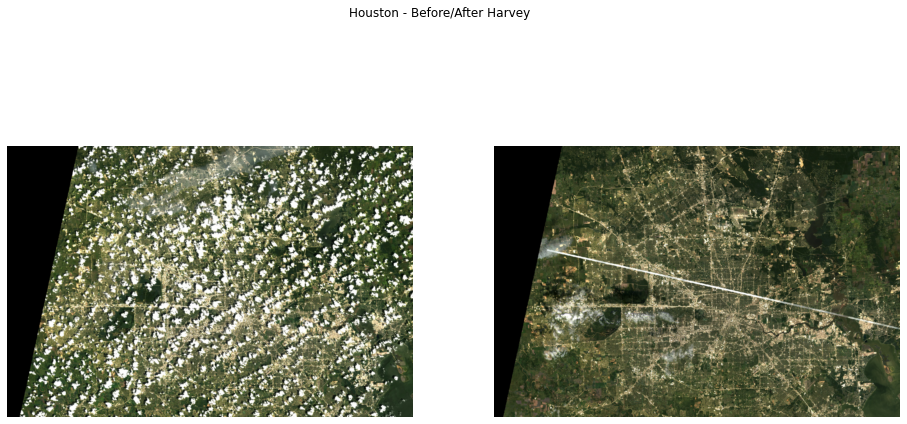

In [12]:
f, axs = plt.subplots(1, 2, figsize=(16, 8))
for i, m in enumerate([map_pre, map_aft]):
    ax = axs[i]
    m.plot(ax=ax)
    ax.set_axis_off()
f.suptitle("Houston - Before/After Harvey")
plt.show()